# Import all Packages

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Data Preparation
1. We will be using the model `deit_base_patch16_224`
  * This means all image need to be reshaped to (224,224)
2. In training, we are using data augmentation process: `RandomHorizontalFlip`. 
  * It is optional step
  *  It randomly flips an input image horizontally
  * It  artificially increase the size and diversity of the training dataset
3. We also normalizes the image `transforms.Normalize`
  * This will reduce the scale of image
  * It helps on Faster convergence, better generalization, and numercial stability


In [ ]:
# Please download the images from `https://www.kaggle.com/datasets/jr2ngb/cataractdataset` and place in your machine's directory
DATA_DIR = "/Users/premtimsina/Documents/bpbbook/chapter7/dataset/"
CLASSES = ["normal", "cataract", "glaucoma", "retina_disease"]

data = []
for class_idx, class_name in enumerate(CLASSES):
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        data.append([img_path, class_idx])

df = pd.DataFrame(data, columns=["image_path", "label"])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class CataractDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = CataractDataset(train_df["image_path"].values, train_df["label"].values, transform=train_transforms)
test_dataset = CataractDataset(test_df["image_path"].values, test_df["label"].values, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)



# Let's review our dataloader
1. We are just viewing the image from train_dataloader
2. There is one very important step:
  * matplotlib need the image in [H, W, C]; where dataloader has image of shape [C, H,W]
  * Thus, before plotting we are transposing so that the data is suitable for viewing for matplotlib

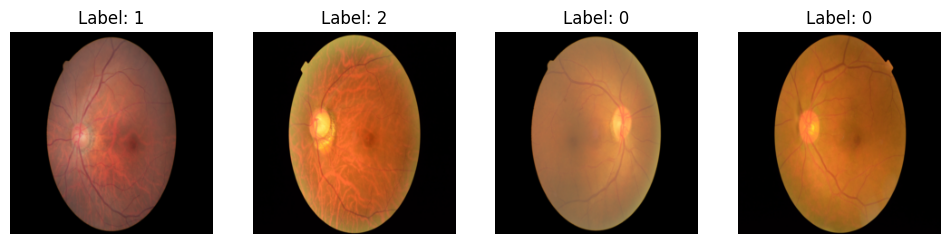

In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

data_iter = iter(train_loader)
images, labels = next(data_iter)

# Function to unnormalize and convert a tensor image to numpy array
def imshow(img_tensor):
    img = img_tensor.numpy()
    # transposing
    img = np.transpose(img, (1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Display the images and their labels
fig, axes = plt.subplots(1, len(images), figsize=(12, 12))

for idx, (image, label) in enumerate(zip(images, labels)):
    axes[idx].imshow(imshow(image))
    axes[idx].set_title(f"Label: {label.item()}")
    axes[idx].axis("off")

plt.show()


# Declare the model
1. We are using the pre-trained model from timm
2. If the image is color, 
  * in_chans=3;
3. if image is graysclae, 
  * in_chans=3=1
4. We need to declare, how many classes we have in out dataset: 
  * For our case, it was 4.
  * num_classes=4
5. `pretrained=True`
  * We are mentioning that we want weight of pre-trained model. If you want to train from scratch, you could just mention 
    * pretrained=False

In [ ]:
import timm
import timm

model = timm.create_model("deit_base_patch16_224", pretrained=True)

# Change the output size of the final linear layer to match the number of classes
num_classes = 4
model.head = torch.nn.Linear(model.head.in_features, num_classes)


Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /Users/premtimsina/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


# Declare the train and test loop
1. In the below code: I am converting output and target into 'cpu'. Somehow my M1 chip is producing the problem. You may not encounter the problem. Thus, this is totally optional step.

In [ ]:
def train(model, device, train_loader, optimizer, criterion, epoch, accelerator):
    model.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        accelerator.backward(loss)
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch: {epoch}, Loss: {avg_loss:.4f}")

from sklearn.metrics import confusion_matrix, recall_score, precision_score

def test(model, device, test_loader, criterion, accelerator):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            output_cpu = output.to('cpu')
            target_cpu=target.to('cpu')
            pred = output_cpu.argmax(dim=1, keepdim=True)
            correct += pred.eq(target_cpu.view_as(pred)).sum().item()
            
            all_preds.extend(pred.flatten().tolist())
            all_targets.extend(target.flatten().tolist())

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Calculate confusion matrix, sensitivity (recall), and specificity
    cm = confusion_matrix(all_targets, all_preds)
    sensitivity = recall_score(all_targets, all_preds, average=None)
    specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)
    
    for i, (sens, spec) in enumerate(zip(sensitivity, specificity)):
        print(f"Class {i}: Sensitivity (Recall): {sens:.4f}, Specificity: {spec:.4f}")



In [ ]:
from accelerate import Accelerator
from torch.optim import Adam

accelerator = Accelerator()
device = accelerator.device
learning_rate = 1e-4

optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_loader, test_loader = accelerator.prepare(train_loader, test_loader)
model, optimizer, criterion = accelerator.prepare(model, optimizer, criterion)





In [ ]:


num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch, accelerator)
    test(model, device, test_loader, criterion, accelerator)

100%|█████████████████████████████████████████| 120/120 [01:11<00:00,  1.68it/s]


Epoch: 1, Loss: 1.1989


/var/folders/dt/v286l_1506x752dg9dwh_yl40000gn/T/ipykernel_62321/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.3381, Accuracy: 35.54%
Class 0: Sensitivity (Recall): 0.2623, Specificity: 0.2000
Class 1: Sensitivity (Recall): 0.9500, Specificity: 0.7564
Class 2: Sensitivity (Recall): 0.4000, Specificity: 0.6522
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.69it/s]


Epoch: 2, Loss: 1.0950
Test Loss: 1.1172, Accuracy: 40.50%
Class 0: Sensitivity (Recall): 0.2787, Specificity: 0.4138
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.1429
Class 2: Sensitivity (Recall): 0.9000, Specificity: 0.7534
Class 3: Sensitivity (Recall): 0.1000, Specificity: 0.6000


100%|█████████████████████████████████████████| 120/120 [01:11<00:00,  1.69it/s]


Epoch: 3, Loss: 1.0110


/var/folders/dt/v286l_1506x752dg9dwh_yl40000gn/T/ipykernel_62321/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.0449, Accuracy: 57.85%
Class 0: Sensitivity (Recall): 0.7213, Specificity: 0.3803
Class 1: Sensitivity (Recall): 0.4500, Specificity: 0.1000
Class 2: Sensitivity (Recall): 0.8500, Specificity: 0.5750
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 4, Loss: 0.8916
Test Loss: 0.8551, Accuracy: 66.12%
Class 0: Sensitivity (Recall): 0.8033, Specificity: 0.3288
Class 1: Sensitivity (Recall): 0.7000, Specificity: 0.4167
Class 2: Sensitivity (Recall): 0.7500, Specificity: 0.2500
Class 3: Sensitivity (Recall): 0.1000, Specificity: 0.5000


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 5, Loss: 0.9009
Test Loss: 0.8480, Accuracy: 66.12%
Class 0: Sensitivity (Recall): 0.8525, Specificity: 0.3333
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.3478
Class 2: Sensitivity (Recall): 0.6000, Specificity: 0.3684
Class 3: Sensitivity (Recall): 0.0500, Specificity: 0.0000


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.71it/s]


Epoch: 6, Loss: 0.7908


/var/folders/dt/v286l_1506x752dg9dwh_yl40000gn/T/ipykernel_62321/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 0.8915, Accuracy: 61.16%
Class 0: Sensitivity (Recall): 0.7541, Specificity: 0.3867
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.3478
Class 2: Sensitivity (Recall): 0.6500, Specificity: 0.4348
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan


100%|█████████████████████████████████████████| 120/120 [01:11<00:00,  1.69it/s]


Epoch: 7, Loss: 0.7330
Test Loss: 0.8084, Accuracy: 68.60%
Class 0: Sensitivity (Recall): 0.8361, Specificity: 0.2917
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.2500
Class 2: Sensitivity (Recall): 0.7500, Specificity: 0.4444
Class 3: Sensitivity (Recall): 0.1000, Specificity: 0.0000


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 8, Loss: 0.6984
Test Loss: 0.9093, Accuracy: 57.85%
Class 0: Sensitivity (Recall): 0.6557, Specificity: 0.3651
Class 1: Sensitivity (Recall): 0.6500, Specificity: 0.0714
Class 2: Sensitivity (Recall): 0.6500, Specificity: 0.5667
Class 3: Sensitivity (Recall): 0.2000, Specificity: 0.7143


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 9, Loss: 0.5615
Test Loss: 0.9382, Accuracy: 63.64%
Class 0: Sensitivity (Recall): 0.8033, Specificity: 0.3553
Class 1: Sensitivity (Recall): 0.8000, Specificity: 0.3600
Class 2: Sensitivity (Recall): 0.6000, Specificity: 0.3684
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000


100%|█████████████████████████████████████████| 120/120 [01:10<00:00,  1.70it/s]


Epoch: 10, Loss: 0.6045
Test Loss: 0.9643, Accuracy: 66.94%
Class 0: Sensitivity (Recall): 0.9344, Specificity: 0.3133
Class 1: Sensitivity (Recall): 0.7000, Specificity: 0.1765
Class 2: Sensitivity (Recall): 0.4000, Specificity: 0.4286
Class 3: Sensitivity (Recall): 0.1000, Specificity: 0.7143


# Analysis:
1. The loss is decreasing. We need more epoch.

# Resnet-50

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
# Load ResNet-50 model
resnet_model = timm.create_model("resnet50", pretrained=True)

# Change the output size of the final linear layer for ResNet-50 to match the number of classes
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, num_classes)

In [ ]:
from accelerate import Accelerator
from torch.optim import Adam

accelerator = Accelerator()
device = accelerator.device
learning_rate = 1e-4

optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_loader, test_loader = accelerator.prepare(train_loader, test_loader)
resnet_model, optimizer, criterion = accelerator.prepare(resnet_model, optimizer, criterion)

In [ ]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(resnet_model, device, train_loader, optimizer, criterion, epoch, accelerator)
    test(resnet_model, device, test_loader, criterion, accelerator)

100%|█████████████████████████████████████████| 120/120 [01:07<00:00,  1.77it/s]


Epoch: 1, Loss: 1.3756
Test Loss: 1.4105, Accuracy: 28.93%
Class 0: Sensitivity (Recall): 0.3115, Specificity: 0.4062
Class 1: Sensitivity (Recall): 0.5000, Specificity: 0.8000
Class 2: Sensitivity (Recall): 0.3000, Specificity: 0.8421
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000


100%|█████████████████████████████████████████| 120/120 [01:08<00:00,  1.76it/s]


Epoch: 2, Loss: 1.3777


/var/folders/dt/v286l_1506x752dg9dwh_yl40000gn/T/ipykernel_62321/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.3482, Accuracy: 33.88%
Class 0: Sensitivity (Recall): 0.3607, Specificity: 0.2667
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.7609
Class 2: Sensitivity (Recall): 0.4000, Specificity: 0.8222
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan


100%|█████████████████████████████████████████| 120/120 [01:08<00:00,  1.75it/s]


Epoch: 3, Loss: 1.3763
Test Loss: 1.3525, Accuracy: 33.06%
Class 0: Sensitivity (Recall): 0.4098, Specificity: 0.3243
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.7692
Class 2: Sensitivity (Recall): 0.1500, Specificity: 0.9032
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000


100%|█████████████████████████████████████████| 120/120 [01:09<00:00,  1.74it/s]


Epoch: 4, Loss: 1.3787
Test Loss: 1.3787, Accuracy: 29.75%
Class 0: Sensitivity (Recall): 0.3443, Specificity: 0.4000
Class 1: Sensitivity (Recall): 0.5000, Specificity: 0.7959
Class 2: Sensitivity (Recall): 0.2500, Specificity: 0.8611
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000


100%|█████████████████████████████████████████| 120/120 [01:08<00:00,  1.76it/s]


Epoch: 5, Loss: 1.3759


/var/folders/dt/v286l_1506x752dg9dwh_yl40000gn/T/ipykernel_62321/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.4205, Accuracy: 29.75%
Class 0: Sensitivity (Recall): 0.2951, Specificity: 0.3793
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.7843
Class 2: Sensitivity (Recall): 0.3500, Specificity: 0.8293
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan


100%|█████████████████████████████████████████| 120/120 [01:08<00:00,  1.76it/s]


Epoch: 6, Loss: 1.3739
Test Loss: 1.3405, Accuracy: 32.23%
Class 0: Sensitivity (Recall): 0.3770, Specificity: 0.4250
Class 1: Sensitivity (Recall): 0.5000, Specificity: 0.7297
Class 2: Sensitivity (Recall): 0.2500, Specificity: 0.8810
Class 3: Sensitivity (Recall): 0.0500, Specificity: 0.5000


100%|█████████████████████████████████████████| 120/120 [01:08<00:00,  1.76it/s]


Epoch: 7, Loss: 1.3761


/var/folders/dt/v286l_1506x752dg9dwh_yl40000gn/T/ipykernel_62321/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.3409, Accuracy: 33.06%
Class 0: Sensitivity (Recall): 0.3443, Specificity: 0.4167
Class 1: Sensitivity (Recall): 0.6500, Specificity: 0.7347
Class 2: Sensitivity (Recall): 0.3000, Specificity: 0.8333
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan


100%|█████████████████████████████████████████| 120/120 [01:08<00:00,  1.74it/s]


Epoch: 8, Loss: 1.3759


/var/folders/dt/v286l_1506x752dg9dwh_yl40000gn/T/ipykernel_62321/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.3343, Accuracy: 35.54%
Class 0: Sensitivity (Recall): 0.4262, Specificity: 0.4222
Class 1: Sensitivity (Recall): 0.5500, Specificity: 0.7381
Class 2: Sensitivity (Recall): 0.3000, Specificity: 0.8235
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan


100%|█████████████████████████████████████████| 120/120 [01:08<00:00,  1.75it/s]


Epoch: 9, Loss: 1.3765


/var/folders/dt/v286l_1506x752dg9dwh_yl40000gn/T/ipykernel_62321/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.3672, Accuracy: 33.88%
Class 0: Sensitivity (Recall): 0.4754, Specificity: 0.4082
Class 1: Sensitivity (Recall): 0.5000, Specificity: 0.7619
Class 2: Sensitivity (Recall): 0.1000, Specificity: 0.9333
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan


100%|█████████████████████████████████████████| 120/120 [01:07<00:00,  1.77it/s]


Epoch: 10, Loss: 1.3765
Test Loss: 1.3480, Accuracy: 38.02%
Class 0: Sensitivity (Recall): 0.4590, Specificity: 0.3488
Class 1: Sensitivity (Recall): 0.4500, Specificity: 0.7353
Class 2: Sensitivity (Recall): 0.4500, Specificity: 0.7907
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000
